In [1]:
import numpy as np
import pandas as pd
import datetime
from collections import OrderedDict
from collections import Counter
import re

In [2]:
nimess_eventlog = pd.read_csv('nimess_features.csv', low_memory=False)

In [ ]:
anino_eventlog = pd.read_csv('anino_eventlog.csv', low_memory=False)

In [ ]:
trfl_eventlog = pd.read_csv('trfl_eventlog.csv', low_memory=False)
nsml_eventlog = pd.read_csv('nsml_eventlog_aggregated.csv', low_memory=False)

In [ ]:
nimess_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
anino_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)
nsml_eventlog.drop(['Unnamed: 0'], axis=1, inplace=True)
trfl_eventlog.drop([ 'Unnamed: 0'], axis=1, inplace=True)

In [5]:
pasient = pd.read_csv('pasient_dec_23.csv')

In [31]:
anino_eventlog

,ppid,ICU_LOS,date_column
0,1,0.875000,2013-10-09
1,1,0.416667,2014-12-30
2,2,0.125000,2018-11-22
3,2,0.083333,2019-11-18
4,3,0.416667,2016-01-07
...,...,...,...
71214,36343,2.291667,2019-07-04
71215,36351,0.250000,2013-07-18
71216,36351,1.041667,2015-10-01
71217,36352,1.291667,2014-12-09


30DAY MORTALITY.............................................................................................................After the last epsiode

In [27]:
# 1. Determine 30-day mortality
# Convert dates to datetime format
pasient['date_of_death'] = pd.to_datetime(pasient['dødsdato'])
nimess_eventlog['last_episode_date'] = pd.to_datetime(nimess_eventlog.groupby('ppid')['utdatotid'].transform('max'))

In [28]:
# Merge to get death date for each patient
df_merged = nimess_eventlog.merge(pasient[['ppid', 'date_of_death']], on='ppid', how='left')

In [29]:
# Calculate 30-day mortality
df_merged['30_day_mortality'] = ((df_merged['date_of_death'] - df_merged['last_episode_date']).dt.days <= 30).astype(int)

In [30]:
df_merged['30_day_mortality'].value_counts()

0    980480
1    347705
Name: 30_day_mortality, dtype: int64

In [34]:
# 2. Aggregated features creation
# a) For nimess_eventlog, already handled above.
# b) For anino_eventlog
anino_eventlog['ICU_LOS_Total'] = anino_eventlog.groupby('ppid')['ICU_LOS'].transform('sum')
df_anino_last = anino_eventlog.sort_values('date_column').drop_duplicates('ppid', keep='last')

In [35]:
df_anino_last.columns

Index(['ppid', 'ICU_LOS', 'date_column', 'ICU_LOS_Total'], dtype='object')

In [36]:
trfl_eventlog['date_column'] = pd.to_datetime(trfl_eventlog['date_column'])

# Calculate the average test results for each test per patient
columns_to_average = ['BILIRUBIN KONJUGERT', 'BILIRUBIN TOTAL', 'BILIRUBIN UKONJUGERT', 'CRP', 'CRP-HØYSENSITIV', 'KREATININ', 'LAKTAT',
                      'LAKTAT BLODGASS', 'LAKTAT BLODGASS VENØST', 'LAKTAT PNA', 'LEUKOCYTTER', 'PH', 'PH PNA', 'PO2', 'PO2 PNA', 'TROMBOCYTTER']
trfl_avg_test_results = trfl_eventlog.groupby('ppid')[columns_to_average].mean().add_suffix('_average').reset_index()

# If you also need the most recent observation for each patient
trfl_latest_observation = trfl_eventlog.sort_values(by=['ppid', 'date_column']).drop_duplicates('ppid', keep='last')
# Now, df_avg_test_results contains the average of each test for each patient
# and df_latest_observation contains the most recent observation for each test for each patient

In [38]:
# Identify all sample type columns (exclude patient id, date, and other non-sample columns)
sample_type_columns = [col for col in nsml_eventlog.columns if col not in ['ppid', 'date_column']]

# Initialize an empty DataFrame for storing positive count results
df_positive_counts = pd.DataFrame()

df_positive_counts['ppid'] = nsml_eventlog['ppid'].unique()  # Add patient_id to the DataFrame

# Loop through each sample type and count positive results
for sample_type in sample_type_columns:
    # Count positive results for each patient for the current sample type
    positive_counts = nsml_eventlog[nsml_eventlog[sample_type] == 'positive'].groupby('ppid').size()
    
    # Join the counts to the df_positive_counts DataFrame
    df_positive_counts = df_positive_counts.merge(positive_counts.rename(f'Positive_{sample_type}_test'), on='ppid', how='left')

df_positive_counts.fillna(0, inplace=True)  # Replace NaN with 0 for patients with no positive results

# Now, df_positive_counts contains the total positive counts for each sample type for each patient.
# This DataFrame can be merged with your features DataFrame as needed.


In [50]:
df_merged.columns.tolist()

['index',
 'ppid',
 'inndatotid',
 'utdatotid',
 'urgency_code',
 'care_level_code',
 'LOS',
 'time_to_last',
 'disease_groups',
 'total_los',
 'prior_comorbidities',
 'kjønn',
 'age',
 'procedure_0',
 'procedure_1',
 'procedure_2',
 'procedure_3',
 'procedure_4',
 'procedure_5',
 'procedure_6',
 'procedure_7',
 'procedure_8',
 'procedure_9',
 'procedure_A',
 'procedure_B',
 'procedure_C',
 'procedure_D',
 'procedure_E',
 'procedure_F',
 'procedure_G',
 'procedure_H',
 'procedure_I',
 'procedure_J',
 'procedure_K',
 'procedure_L',
 'procedure_M',
 'procedure_N',
 'procedure_O',
 'procedure_P',
 'procedure_Q',
 'procedure_R',
 'procedure_S',
 'procedure_T',
 'procedure_U',
 'procedure_V',
 'procedure_W',
 'procedure_X',
 'procedure_Y',
 'procedure_Z',
 'ICD_0',
 'ICD_1',
 'ICD_2',
 'ICD_3',
 'ICD_4',
 'ICD_5',
 'ICD_6',
 'ICD_7',
 'ICD_8',
 'ICD_9',
 'ICD_A',
 'ICD_B',
 'ICD_C',
 'ICD_D',
 'ICD_E',
 'ICD_F',
 'ICD_G',
 'ICD_H',
 'ICD_I',
 'ICD_J',
 'ICD_K',
 'ICD_L',
 'ICD_M',
 'ICD_N',

In [46]:
# Merge all features into a single DataFrame
df_features = df_merged[['ppid', '30_day_mortality', ]].drop_duplicates()
df_features = df_features.merge(df_anino_last[['ppid', 'ICU_LOS_Total', 'ICU_LOS']], on='ppid', how='left')
df_features = df_features.merge(trfl_avg_test_results, on='ppid', how='left')
df_features = df_features.merge(trfl_latest_observation, on='ppid', how='left')
df_features = df_features.merge(df_positive_counts, on='ppid', how='left')
# Now df_features contains all necessary features and labels for modeling

In [51]:
df_features['30_day_mortality'].value_counts()

0    28173
1     7418
Name: 30_day_mortality, dtype: int64

In [52]:
df_nimess_sorted = nimess_eventlog.sort_values(by=['ppid', 'inndatotid'])
df_nimess_last_entry = df_nimess_sorted.drop_duplicates(subset='ppid', keep='last')
df_features = df_features.merge(df_nimess_last_entry, on='ppid', how='left')

In [60]:
df_features = df_features.drop('disease_groups', axis=1)

In [61]:
df_features.prior_comorbidities

0                                         {cardiovascular}
1                      {urinarytractinfection, infection,}
2                                              {infection}
3        {organdysfunction, skinandsofttissueinfection,...
4                                              {infection}
                               ...                        
35586                                                   {}
35587                                  {cancer, infection}
35588                            {cardiovascular,, cancer}
35589                                                   {}
35590                                                   {}
Name: prior_comorbidities, Length: 35591, dtype: object

In [62]:
# Function to count unique comorbidities from string, assuming each comorbidity is separated by commas
def count_unique_comorbidities(comorbidity_str):
    # Remove curly braces and split by comma, then strip whitespace and filter out empty strings
    comorbidities = [c.strip() for c in comorbidity_str.strip('{}').split(',') if c.strip()]
    # Return the count of unique comorbidities
    return len(set(comorbidities))

# Apply the function to the 'prior_comorbidities' column
df_features['prior_comorbidities_counts'] = df_features['prior_comorbidities'].apply(count_unique_comorbidities)

# Now, 'prior_comorbidities' will contain numerical values.


In [64]:
df_features = df_features.drop('prior_comorbidities', axis=1)

In [66]:
df_features.to_csv('30Dmortalitydata.csv')

In [2]:
df_features = pd.read_csv('30Dmortalitydata.csv', low_memory=False)
df_features.drop(['Unnamed: 0'], axis=1, inplace=True)

In [3]:
df_features.columns.tolist()

['ppid',
 '30_day_mortality',
 'ICU_LOS_Total',
 'ICU_LOS',
 'BILIRUBIN KONJUGERT_average',
 'BILIRUBIN TOTAL_average',
 'BILIRUBIN UKONJUGERT_average',
 'CRP_average',
 'CRP-HØYSENSITIV_average',
 'KREATININ_average',
 'LAKTAT_average',
 'LAKTAT BLODGASS_average',
 'LAKTAT BLODGASS VENØST_average',
 'LAKTAT PNA_average',
 'LEUKOCYTTER_average',
 'PH_average',
 'PH PNA_average',
 'PO2_average',
 'PO2 PNA_average',
 'TROMBOCYTTER_average',
 'BILIRUBIN KONJUGERT',
 'BILIRUBIN TOTAL',
 'BILIRUBIN UKONJUGERT',
 'CRP',
 'CRP-HØYSENSITIV',
 'KREATININ',
 'LAKTAT',
 'LAKTAT BLODGASS',
 'LAKTAT BLODGASS VENØST',
 'LAKTAT PNA',
 'LEUKOCYTTER',
 'PH',
 'PH PNA',
 'PO2',
 'PO2 PNA',
 'TROMBOCYTTER',
 'date_column_x',
 'Positive_annet_test',
 'Positive_anus_test',
 'Positive_bein_test',
 'Positive_biopsi_test',
 'Positive_blod_test',
 'Positive_blood_culture_test_test',
 'Positive_bronki_test',
 'Positive_melk_test',
 'Positive_edta_test',
 'Positive_faeces_test',
 'Positive_hal_test',
 'Positive_

In [4]:
df_features = df_features.drop('inndatotid', axis=1)

In [5]:
df_features = df_features.drop('utdatotid', axis=1)
df_features = df_features.drop('date_column_x', axis=1)
df_features = df_features.drop('date_column_y', axis=1)
df_features = df_features.drop('last_episode_date', axis=1)

In [6]:
df_features['Gender'] = df_features['kjønn'].map({'Mann': 1, 'Kvinne': 0})
df_features = df_features.drop('kjønn', axis=1)

In [7]:
df_features.fillna(0, inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming '30_day_mortality' is the target variable
X = df_features.drop('30_day_mortality', axis=1)
y = df_features['30_day_mortality']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features (important for neural networks and logistic regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
!pip install xgboost lightgbm catboost scikit-learn keras tensorflow

     |████████████████████████████████| 1.8 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 69.2 MB 353 kB/s eta 0:00:012
  Installing build dependencies ... error
  ERROR: Command errored out with exit status 2:
   command: /Users/rajeevbopche/opt/anaconda3/envs/tensorflow/bin/python /private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-standalone-pip-bop5x9x2/__env_pip__.zip/pip install --ignore-installed --no-user --prefix /private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-build-env-drn8ae2f/overlay --no-warn-script-location --no-binary :none: --only-binary :none: -i https://pypi.org/simple -- 'setuptools >= 64.0' wheel 'jupyterlab (>=3.0.6, == 3.*)' 'conan ~= 1.62'
       cwd: None
  Complete output (172 lines):
  ERROR: Exception:
  Traceback (most recent call last):
    File "/private/var/folders/jv/7pzn0fgj2tdb9blxxhhxqv000000gn/T/pip-standalone-pip-bop5x9x2/__env_pip__.zip/pip/_vendor/urllib3/response.py", line 438, in _error_catcher
      yield

In [79]:
!pip3 install lightgbm

  Using cached lightgbm-4.3.0-py3-none-macosx_10_15_x86_64.macosx_11_6_x86_64.macosx_12_5_x86_64.whl (1.8 MB)


In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix

# Define a simple neural network model for binary classification
def build_nn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    #"LightGBM": LGBMClassifier(random_state=42),
   # "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "Neural Network": build_nn(X_train_scaled.shape[1])
}

# Train each model and evaluate on the test set
results = {}
for name, model in models.items():
    if name == "Neural Network":  # NN requires scaled data
        model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)
        y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).reshape(-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn+fp)
    aucpr = roc_auc_score(y_test, y_pred)  # Use AUC-PR as a proxy for AUPRC; for exact AUPRC, consider using sklearn.metrics.average_precision_score
    
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity,
        "AUPRC": aucpr
    }


/Users/rajeevbopche/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [85]:
results

{'Random Forest': {'Accuracy': 0.9036381514257621,
  'Precision': 0.8472103004291845,
  'Recall': 0.6602006688963211,
  'F1 Score': 0.7421052631578947,
  'Specificity': 0.9683499288762447,
  'AUPRC': 0.8142752988862829},
 'Logistic Regression': {'Accuracy': 0.8352296670880741,
  'Precision': 0.6854838709677419,
  'Recall': 0.3979933110367893,
  'F1 Score': 0.5035971223021583,
  'Specificity': 0.9514580369843528,
  'AUPRC': 0.674725674010571},
 'XGBoost': {'Accuracy': 0.9145947464531535,
  'Precision': 0.8258633357825128,
  'Recall': 0.7518394648829432,
  'F1 Score': 0.7871148459383753,
  'Specificity': 0.9578591749644382,
  'AUPRC': 0.8548493199236906},
 'Neural Network': {'Accuracy': 0.8908554572271387,
  'Precision': 0.7517531556802244,
  'Recall': 0.717056856187291,
  'F1 Score': 0.733995207120849,
  'Specificity': 0.9370554765291608,
  'AUPRC': 0.8270561663582259}}

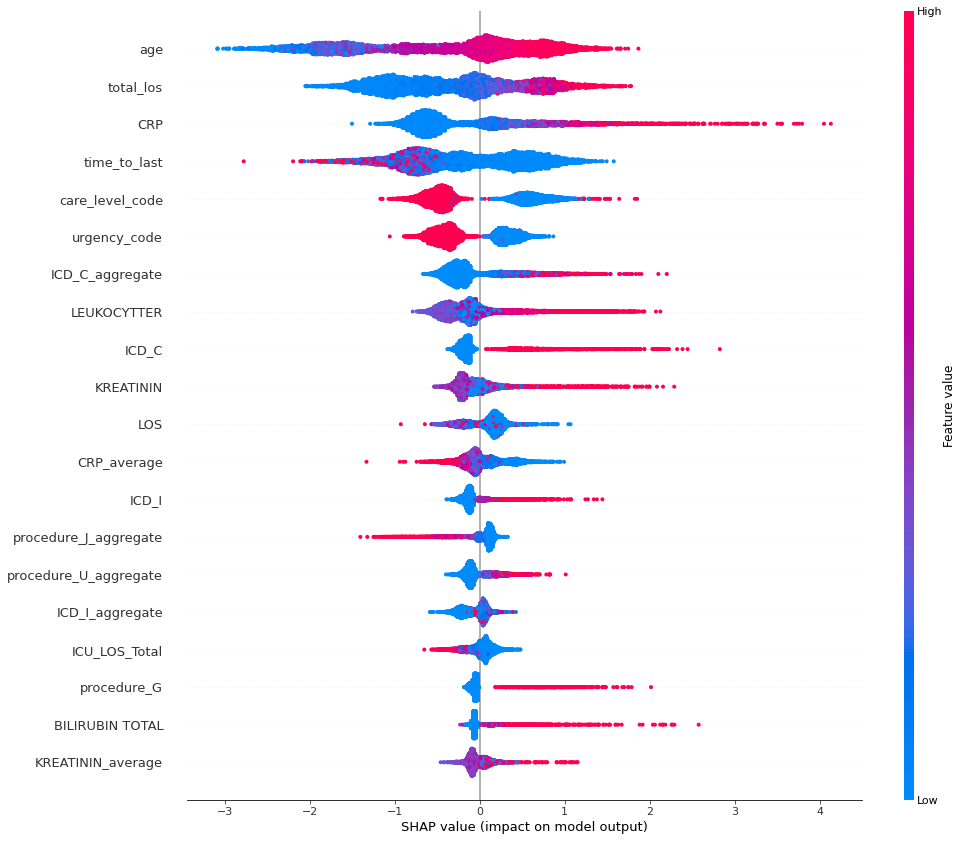

In [9]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Your data preparation step here
# X = ...  # Feature DataFrame
# y = ...  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model.fit(X_train, y_train)

# Initialize the SHAP Explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Plot SHAP summary dot plot
feature_names = X_test.columns.tolist()
shap.summary_plot(shap_values, features=X_test, feature_names=feature_names, show=False)

# Save the plot as a high-quality PNG file
plt.gcf().set_size_inches(18, 12)  # Adjust the size as needed
plt.savefig("30daymort_shap_summary_plot.png", bbox_inches='tight', dpi=300)

In [12]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency
import statsmodels.api as sm

# Assuming df is your DataFrame and '30_day_mortality' is the target
X = df_features.drop('30_day_mortality', axis=1)  # All features except the target
y = df_features['30_day_mortality']  # Target variable

# Separate the DataFrame into two based on the target value
group0 = df_features[df_features['30_day_mortality'] == 0]
group1 = df_features[df_features['30_day_mortality'] == 1]

# Initialize a dictionary to store test results
test_results = {}

# Mann-Whitney U test for numerical features
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    stat, p_value = mannwhitneyu(group0[feature], group1[feature], alternative='two-sided')
    test_results[feature] = {'Stat': stat, 'P-Value': p_value}

# Chi-square test for the categorical feature (gender)
categorical_features = ['Gender', 'care_level_code', 'urgency_code']  # Add any categorical feature names here
for feature in categorical_features:
    contingency_table = pd.crosstab(df_features[feature], y)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    test_results[feature] = {'Chi2 Stat': chi2, 'P-Value': p_value}

# Convert the test results to a DataFrame for easier viewing
test_results_df = pd.DataFrame(test_results).T

# Display the results
print(test_results_df)


                                    Stat        P-Value  Chi2 Stat
ppid                         104557209.0   9.356648e-01        NaN
ICU_LOS_Total                 89041514.0   1.557942e-89        NaN
ICU_LOS                       90988090.5   6.596823e-70        NaN
BILIRUBIN KONJUGERT_average  103837037.0   6.814874e-04        NaN
BILIRUBIN TOTAL_average       94705696.0   8.210433e-36        NaN
...                                  ...            ...        ...
procedure_X_aggregate        101497771.5   3.882771e-37        NaN
procedure_Y_aggregate        102541509.5  8.605981e-105        NaN
procedure_Z_aggregate        110298205.0   3.580080e-16        NaN
prior_comorbidities_counts    82260989.5  1.066131e-197        NaN
Gender                               NaN   3.376618e-15  62.033512

[221 rows x 3 columns]


In [13]:
test_results_df

,Stat,P-Value,Chi2 Stat
ppid,104557209.0,9.356648e-01,NaN
ICU_LOS_Total,89041514.0,1.557942e-89,NaN
ICU_LOS,90988090.5,6.596823e-70,NaN
BILIRUBIN KONJUGERT_average,103837037.0,6.814874e-04,NaN
BILIRUBIN TOTAL_average,94705696.0,8.210433e-36,NaN
...,...,...,...
procedure_X_aggregate,101497771.5,3.882771e-37,NaN
procedure_Y_aggregate,102541509.5,8.605981e-105,NaN
procedure_Z_aggregate,110298205.0,3.580080e-16,NaN
prior_comorbidities_counts,82260989.5,1.066131e-197,NaN


In [14]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, chi2_contingency

# Assuming df is your DataFrame and '30_day_mortality' is the target
X = df_features.drop('30_day_mortality', axis=1)  # All features except the target
y = df_features['30_day_mortality']  # Target variable

# Separate the DataFrame into two based on the target value
group0 = df_features[df_features['30_day_mortality'] == 0]
group1 = df_features[df_features['30_day_mortality'] == 1]

# Initialize a dictionary to store test results including means
test_results = {}

# Mann-Whitney U test for numerical features + mean calculations
numerical_features = X.select_dtypes(include=[np.number]).columns.tolist()
for feature in numerical_features:
    stat, p_value = mannwhitneyu(group0[feature], group1[feature], alternative='two-sided')
    mean_class_0 = group0[feature].mean()
    mean_class_1 = group1[feature].mean()
    test_results[feature] = {'Stat': stat, 'P-Value': p_value, 'Mean (Class 0)': mean_class_0, 'Mean (Class 1)': mean_class_1}

# Chi-square test for the categorical feature (gender) + mean calculations
categorical_features = ['Gender', 'care_level_code', 'urgency_code']  # Add any categorical feature names here
for feature in categorical_features:
    contingency_table = pd.crosstab(df_features[feature], y)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    mean_class_0 = group0[feature].value_counts(normalize=True).max()  # Proportion of most common category in class 0
    mean_class_1 = group1[feature].value_counts(normalize=True).max()  # Proportion of most common category in class 1
    test_results[feature] = {'Chi2 Stat': chi2, 'P-Value': p_value, 'Proportion (Class 0)': mean_class_0, 'Proportion (Class 1)': mean_class_1}

# Convert the test results to a DataFrame for easier viewing
test_results_df = pd.DataFrame(test_results).T

# Sort the results by p-value to highlight the most significant features
test_results_df = test_results_df.sort_values('P-Value')

# Display the results
print(test_results_df)


                        Stat  P-Value  Mean (Class 0)  Mean (Class 1)  \
urgency_code             NaN      0.0             NaN             NaN   
ICD_J_aggregate   75051088.0      0.0        2.105846        4.130493   
ICD_I_aggregate   70409711.5      0.0        5.215171        8.984632   
CRP               54503172.5      0.0       20.847212       82.776984   
ICD_C_aggregate   66088361.5      0.0        5.717992       21.923160   
...                      ...      ...             ...             ...   
ICD_6_aggregate  104493657.0      1.0        0.000000        0.000000   
ICD_8_aggregate  104493657.0      1.0        0.000000        0.000000   
ICD_9_aggregate  104493657.0      1.0        0.000000        0.000000   
procedure_7      104493657.0      1.0        0.000000        0.000000   
ICD_7_aggregate  104493657.0      1.0        0.000000        0.000000   

                   Chi2 Stat  Proportion (Class 0)  Proportion (Class 1)  
urgency_code     3476.871964              0.6887

In [15]:
test_results_df.to_csv('30Dmortality_stats.csv')